In [209]:
import pandas as pd
import numpy as np
import pickle
import math
from StringContains import ContainedStringCase 
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import os
from scipy.stats import ks_2samp, ttest_rel, f, mannwhitneyu, pearsonr, spearmanr, kendalltau
from jmh_parser import parseFile
from benchmarkutils import get_data_frame_from_csv, get_ks_2sample_test_log, get_mann_whitney_u_test_test_log, read_log
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [118]:
os.chdir("/Users/pw/eclipse-workspace/JMHRegexPerf")
http2_dir_1 = "http2/"
http2_dir_3 = "http2_shuffle2/"
http1 = "http1/"
http0 = "http0/"
http3 = "http3/"
ratio0 = "http5ratio0.9/"
ratio1 = "http6ratio0.9/"
ratio2 = "http7ratio0.9/"
ratio3 = "http8ratio0.9/"
http_nonmatching = "http9nonmatching/"
http_nonmatching0 = "http10nonmatching/"
http_nonmatching1 = "http11nonmatching/"
http_nonmatching2 = "http12nonmatching/"
http_nonmatching3 = "http13nonmatching/"

In [119]:
def getDataFrameConcated(list_dirs):
    df = pd.concat(map(get_data_frame_from_csv, list_dirs))
    print("loading all files: ", df.shape)
    df = pd.melt(df, id_vars=['str_len', 'match_pos_ratio'], value_vars=['regexMatches', 'stringContains'])
    print("melting data frame and use benchmark as a method:", df.dtypes, df.shape)
    df = df.astype({"str_len":"int", "match_pos_ratio":"float"})
    df["matches"] = df["match_pos_ratio"] != 1.0
    df['match_pos'] = df['str_len'] * df['match_pos_ratio']
    df['match_pos'] = df['match_pos'].round().astype(int)
    print("adding variable match_pos and matches into the data frame:", df.dtypes, df.shape)
    return df

In [120]:
df1 = getDataFrameConcated([http2_dir_1])
df_same_inputstr = getDataFrameConcated([http2_dir_1,http2_dir_3])
df_same_regex = getDataFrameConcated([http2_dir_1,http0,http1,http3])
df_same_regex_new = getDataFrameConcated([http2_dir_1,http0,http1,http3,ratio0,ratio1,ratio2,ratio3])
df_same_regex_new_nonmatching = getDataFrameConcated([http_nonmatching, http2_dir_1,http0,http1,http3,ratio0,ratio1,ratio2,ratio3])
df_same_regex_new_nonmatching2 = getDataFrameConcated([http_nonmatching0, http_nonmatching1, http_nonmatching2, http_nonmatching3,http2_dir_1,http0,http1,http3,ratio0,ratio1,ratio2,ratio3])

loading all files:  (71, 7)
melting data frame and use benchmark as a method: str_len            object
match_pos_ratio    object
Benchmark          object
value               int64
dtype: object (142, 4)
adding variable match_pos and matches into the data frame: str_len              int64
match_pos_ratio    float64
Benchmark           object
value                int64
matches               bool
match_pos            int64
dtype: object (142, 6)
loading all files:  (142, 7)
melting data frame and use benchmark as a method: str_len            object
match_pos_ratio    object
Benchmark          object
value               int64
dtype: object (284, 4)
adding variable match_pos and matches into the data frame: str_len              int64
match_pos_ratio    float64
Benchmark           object
value                int64
matches               bool
match_pos            int64
dtype: object (284, 6)
loading all files:  (284, 7)
melting data frame and use benchmark as a method: str_len            obj

In [272]:
formula1 = 'value ~ C(Benchmark) + C(str_len) + C(match_pos_ratio)'
formula2 = 'value ~ C(Benchmark) + C(str_len) + C(match_pos)'
formula3 = 'value ~ C(Benchmark) + C(str_len) + C(matches)' 
formula4 = 'value ~ C(Benchmark) + C(str_len) + C(match_pos_ratio) + C(matches)'
formula4_continuous = 'value ~ C(Benchmark) + str_len + match_pos_ratio + C(matches)'
formula5 = 'value ~ C(Benchmark) + C(str_len) + C(match_pos) + C(matches)'
formula5_continuous = 'value ~ C(Benchmark) + str_len + match_pos + C(matches)'

In [122]:
df1.head()

,str_len,match_pos_ratio,Benchmark,value,matches,match_pos
0,1024,0.00,regexMatches,7862,True,0
1,1024,0.25,regexMatches,6201,True,256
2,1024,0.50,regexMatches,4631,True,512
3,1024,0.75,regexMatches,2070,True,768
4,1024,1.00,regexMatches,5563,False,1024


In [125]:
anova_df1 = sm.stats.anova_lm(ols(formula1, data = df1).fit(), typ = 3)
anova_df_same_inputstr = sm.stats.anova_lm(ols(formula1, data = df_same_inputstr).fit(), typ = 3)
anova_df_same_regex = sm.stats.anova_lm(ols(formula1, data = df_same_regex).fit(), typ = 3)
anova_df_same_regex_new = sm.stats.anova_lm(ols(formula1, data = df_same_regex_new).fit(), typ = 3)
anova_df_same_regex_new_nonmatching = sm.stats.anova_lm(ols(formula1, data = df_same_regex_new_nonmatching).fit(), typ = 3)
anova_df_same_regex_new_nonmatching2 = sm.stats.anova_lm(ols(formula1, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
pd.concat([anova_df1,anova_df_same_inputstr, anova_df_same_regex])

,sum_sq,df,F,PR(>F)
Intercept,2.570636e+09,1.0,0.784435,3.775307e-01
C(Benchmark),7.026648e+10,1.0,21.441952,9.187859e-06
C(str_len),2.947309e+11,14.0,6.424122,1.563883e-09
C(match_pos_ratio),1.309507e+10,4.0,0.998996,4.109067e-01
Residual,3.998009e+11,122.0,NaN,NaN
Intercept,5.123661e+09,1.0,1.710136,1.921054e-01
C(Benchmark),1.393054e+11,1.0,46.496274,6.230115e-11
C(str_len),5.824413e+11,14.0,13.885911,1.238959e-24
C(match_pos_ratio),2.578690e+10,4.0,2.151738,7.483988e-02
Residual,7.909585e+11,264.0,NaN,NaN


In [126]:
pd.concat([anova_df_same_regex_new,anova_df_same_regex_new_nonmatching, anova_df_same_regex_new_nonmatching2])

,sum_sq,df,F,PR(>F)
Intercept,8.109792e+09,1.0,3.187155,7.469031e-02
C(Benchmark),2.409516e+11,1.0,94.694190,5.709017e-21
C(str_len),9.821863e+11,14.0,27.571434,1.049147e-56
C(match_pos_ratio),8.681243e+10,5.0,6.823472,3.250740e-06
Residual,1.636129e+12,643.0,NaN,NaN
Intercept,9.509974e+09,1.0,3.753388,5.311867e-02
C(Benchmark),2.567543e+11,1.0,101.335545,2.676558e-22
C(str_len),1.049915e+12,14.0,29.598543,5.188857e-61
C(match_pos_ratio),8.817631e+10,5.0,6.960269,2.373756e-06
Residual,1.705183e+12,673.0,NaN,NaN


In [127]:
def getShortString(df):
    return df.loc[df["str_len"]<2048,:]

anova_df_same_regex = sm.stats.anova_lm(ols(formula1, data = getShortString(df_same_regex)).fit(), typ = 3)
anova_df_same_regex_new = sm.stats.anova_lm(ols(formula1, data = getShortString(df_same_regex_new)).fit(), typ = 3)
anova_df_same_regex_new_nonmatching = sm.stats.anova_lm(ols(formula1, data = getShortString(df_same_regex_new_nonmatching)).fit(), typ = 3)
anova_df_same_regex_new_nonmatching2 = sm.stats.anova_lm(ols(formula1, data = getShortString(df_same_regex_new_nonmatching2)).fit(), typ = 3)
pd.concat([anova_df_same_regex,anova_df_same_regex_new,anova_df_same_regex_new_nonmatching, anova_df_same_regex_new_nonmatching2])

,sum_sq,df,F,PR(>F)
Intercept,1.235559e+07,1.0,12.398504,4.933337e-04
C(Benchmark),1.639646e+08,1.0,164.534113,1.425615e-30
C(str_len),2.507828e+08,8.0,31.456735,4.452393e-36
C(match_pos_ratio),2.173964e+07,4.0,5.453787,2.947064e-04
Residual,3.129132e+08,314.0,NaN,NaN
Intercept,1.072412e+07,1.0,11.204278,9.019786e-04
C(Benchmark),1.539930e+08,1.0,160.887859,9.619104e-31
C(str_len),2.323352e+08,8.0,30.342230,3.281890e-36
C(match_pos_ratio),4.370683e+07,5.0,9.132753,3.405462e-08
Residual,3.455292e+08,361.0,NaN,NaN


In [128]:
anova_df1 = sm.stats.anova_lm(ols(formula2, data = df1).fit(), typ = 3)
anova_df_same_inputstr = sm.stats.anova_lm(ols(formula2, data = df_same_inputstr).fit(), typ = 3)
anova_df_same_regex = sm.stats.anova_lm(ols(formula2, data = df_same_regex).fit(), typ = 3)
anova_df_same_regex_new = sm.stats.anova_lm(ols(formula2, data = df_same_regex_new).fit(), typ = 3)
anova_df_same_regex_new_nonmatching = sm.stats.anova_lm(ols(formula2, data = df_same_regex_new_nonmatching).fit(), typ = 3)
anova_df_same_regex_new_nonmatching2 = sm.stats.anova_lm(ols(formula2, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
pd.concat([anova_df1,anova_df_same_inputstr, anova_df_same_regex])

,sum_sq,df,F,PR(>F)
Intercept,1.502208e+09,1.0,0.403163,5.269551e-01
C(Benchmark),7.026648e+10,1.0,18.858141,3.462644e-05
C(str_len),1.733412e+11,14.0,3.322955,2.335686e-04
C(match_pos),5.146854e+10,29.0,0.476315,9.875618e-01
Residual,3.614274e+11,97.0,NaN,NaN
Intercept,2.977295e+09,1.0,0.994417,3.196738e-01
C(Benchmark),1.393054e+11,1.0,46.528016,7.344593e-11
C(str_len),3.450606e+11,14.0,8.232164,2.388874e-14
C(match_pos),1.011768e+11,29.0,1.165278,2.636465e-01
Residual,7.155686e+11,239.0,NaN,NaN


In [129]:
pd.concat([anova_df_same_regex_new,anova_df_same_regex_new_nonmatching, anova_df_same_regex_new_nonmatching2])

,sum_sq,df,F,PR(>F)
Intercept,4.427456e+09,1.0,1.949877,1.631105e-01
C(Benchmark),2.409516e+11,1.0,106.116476,4.824282e-23
C(str_len),6.504854e+11,14.0,20.462682,1.458026e-42
C(match_pos),3.446667e+11,41.0,3.702273,1.064797e-12
Residual,1.378274e+12,607.0,NaN,NaN
Intercept,4.718075e+09,1.0,2.075461,1.501760e-01
C(Benchmark),2.567543e+11,1.0,112.945119,2.130824e-24
C(str_len),6.515657e+11,14.0,20.472929,5.856833e-43
C(match_pos),3.452888e+11,41.0,3.704660,8.650340e-13
Residual,1.448070e+12,637.0,NaN,NaN


In [130]:
anova_df_same_regex = sm.stats.anova_lm(ols(formula2, data = getShortString(df_same_regex)).fit(), typ = 3)
anova_df_same_regex_new = sm.stats.anova_lm(ols(formula2, data = getShortString(df_same_regex_new)).fit(), typ = 3)
anova_df_same_regex_new_nonmatching = sm.stats.anova_lm(ols(formula2, data = getShortString(df_same_regex_new_nonmatching)).fit(), typ = 3)
anova_df_same_regex_new_nonmatching2 = sm.stats.anova_lm(ols(formula2, data = getShortString(df_same_regex_new_nonmatching2)).fit(), typ = 3)
pd.concat([anova_df_same_regex,anova_df_same_regex_new,anova_df_same_regex_new_nonmatching, anova_df_same_regex_new_nonmatching2])

,sum_sq,df,F,PR(>F)
Intercept,7.191655e+06,1.0,7.511576,6.496729e-03
C(Benchmark),1.639646e+08,1.0,171.258603,2.755890e-31
C(str_len),1.469255e+08,8.0,19.182690,2.786503e-23
C(match_pos),4.647254e+07,17.0,2.855287,1.665056e-04
Residual,2.881803e+08,301.0,NaN,NaN
Intercept,6.033648e+06,1.0,6.882054,9.095323e-03
C(Benchmark),1.539930e+08,1.0,175.646277,1.172702e-32
C(str_len),1.469255e+08,8.0,20.948133,7.465212e-26
C(match_pos),8.852041e+07,23.0,4.389890,4.578681e-10
Residual,3.007157e+08,343.0,NaN,NaN


In [131]:
anova_df1 = sm.stats.anova_lm(ols(formula3, data = df1).fit(), typ = 3)
anova_df_same_inputstr = sm.stats.anova_lm(ols(formula3, data = df_same_inputstr).fit(), typ = 3)
anova_df_same_regex = sm.stats.anova_lm(ols(formula3, data = df_same_regex).fit(), typ = 3)
anova_df_same_regex_new = sm.stats.anova_lm(ols(formula3, data = df_same_regex_new).fit(), typ = 3)
anova_df_same_regex_new_nonmatching = sm.stats.anova_lm(ols(formula3, data = df_same_regex_new_nonmatching).fit(), typ = 3)
anova_df_same_regex_new_nonmatching2 = sm.stats.anova_lm(ols(formula3, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
pd.concat([anova_df1,anova_df_same_inputstr, anova_df_same_regex])

,sum_sq,df,F,PR(>F)
Intercept,2.275589e+09,1.0,0.689796,4.078171e-01
C(Benchmark),7.026648e+10,1.0,21.299790,9.594338e-06
C(str_len),2.919413e+11,14.0,6.321128,1.971430e-09
C(matches),5.298826e+08,1.0,0.160623,6.892681e-01
Residual,4.123661e+11,125.0,NaN,NaN
Intercept,4.465424e+09,1.0,1.461465,2.277666e-01
C(Benchmark),1.393054e+11,1.0,45.592538,9.056032e-11
C(str_len),5.769390e+11,14.0,13.487384,4.833009e-24
C(matches),9.421777e+08,1.0,0.308360,5.791530e-01
Residual,8.158032e+11,267.0,NaN,NaN


In [132]:
pd.concat([anova_df_same_regex_new,anova_df_same_regex_new_nonmatching, anova_df_same_regex_new_nonmatching2])

,sum_sq,df,F,PR(>F)
Intercept,8.050688e+09,1.0,3.034341,8.199485e-02
C(Benchmark),2.409516e+11,1.0,90.815765,3.111351e-20
C(str_len),9.607683e+11,14.0,25.865571,1.337169e-53
C(matches),6.326311e+09,1.0,2.384416,1.230397e-01
Residual,1.716615e+12,647.0,NaN,NaN
Intercept,8.923734e+09,1.0,3.382994,6.631003e-02
C(Benchmark),2.567543e+11,1.0,97.335724,1.528168e-21
C(str_len),1.028361e+12,14.0,27.846597,7.550640e-58
C(matches),7.553862e+09,1.0,2.863674,9.106048e-02
Residual,1.785805e+12,677.0,NaN,NaN


In [133]:
anova_df_same_regex = sm.stats.anova_lm(ols(formula3, data = getShortString(df_same_regex)).fit(), typ = 3)
anova_df_same_regex_new = sm.stats.anova_lm(ols(formula3, data = getShortString(df_same_regex_new)).fit(), typ = 3)
anova_df_same_regex_new_nonmatching = sm.stats.anova_lm(ols(formula3, data = getShortString(df_same_regex_new_nonmatching)).fit(), typ = 3)
anova_df_same_regex_new_nonmatching2 = sm.stats.anova_lm(ols(formula3, data = getShortString(df_same_regex_new_nonmatching2)).fit(), typ = 3)
pd.concat([anova_df_same_regex,anova_df_same_regex_new,anova_df_same_regex_new_nonmatching, anova_df_same_regex_new_nonmatching2])

,sum_sq,df,F,PR(>F)
Intercept,7.943078e+06,1.0,7.525390,6.429681e-03
C(Benchmark),1.639646e+08,1.0,155.342503,2.741386e-29
C(str_len),2.422911e+08,8.0,28.693767,1.670567e-33
C(matches),5.806790e+04,1.0,0.055014,8.147083e-01
Residual,3.345947e+08,317.0,NaN,NaN
Intercept,7.703883e+06,1.0,7.229852,7.498925e-03
C(Benchmark),1.539930e+08,1.0,144.517564,2.838424e-28
C(str_len),2.132386e+08,8.0,25.014723,1.079848e-30
C(matches),3.045816e+05,1.0,0.285840,5.932241e-01
Residual,3.889315e+08,365.0,NaN,NaN


In [273]:
anova_df1 = sm.stats.anova_lm(ols(formula4, data = df1).fit(), typ = 3)
anova_df_same_inputstr = sm.stats.anova_lm(ols(formula4, data = df_same_inputstr).fit(), typ = 3)
anova_df_same_regex = sm.stats.anova_lm(ols(formula4, data = df_same_regex).fit(), typ = 3)
anova_df_same_regex_new = sm.stats.anova_lm(ols(formula4, data = df_same_regex_new).fit(), typ = 3)
anova_df_same_regex_new_nonmatching = sm.stats.anova_lm(ols(formula4, data = df_same_regex_new_nonmatching).fit(), typ = 3)
anova_df_same_regex_new_nonmatching2 = sm.stats.anova_lm(ols(formula4, data = df_same_regex_new_nonmatching2).fit(), typ = 3)

In [135]:
pd.concat([anova_df_same_regex_new,anova_df_same_regex_new_nonmatching, anova_df_same_regex_new_nonmatching2])

,sum_sq,df,F,PR(>F)
Intercept,5.702533e+09,1.0,2.241101,1.348760e-01
C(Benchmark),2.409516e+11,1.0,94.694190,5.709017e-21
C(str_len),9.821863e+11,14.0,27.571434,1.049147e-56
C(match_pos_ratio),9.167100e+10,5.0,7.205357,1.414119e-06
C(matches),1.029694e+10,1.0,4.046705,4.467437e-02
Residual,1.636129e+12,643.0,NaN,NaN
Intercept,6.859798e+09,1.0,2.707419,1.003494e-01
C(Benchmark),2.567543e+11,1.0,101.335545,2.676558e-22
C(str_len),1.049915e+12,14.0,29.598543,5.188857e-61
C(match_pos_ratio),9.340702e+10,5.0,7.373160,9.625511e-07


In [274]:
anova_df_same_regex_new_nonmatching2

,sum_sq,df,F,PR(>F)
Intercept,1.041457e+10,1.0,4.168751,4.151957e-02
C(Benchmark),3.037021e+11,1.0,121.566015,2.474700e-26
C(str_len),1.252247e+12,14.0,35.803564,3.881833e-74
C(match_pos_ratio),9.815895e+10,5.0,7.858222,3.153362e-07
C(matches),1.551546e+10,1.0,6.210537,1.291039e-02
Residual,1.906163e+12,763.0,NaN,NaN


In [279]:
anova_df_same_regex_new_nonmatching2.to_latex(index=True)

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &        sum\\_sq &     df &           F &        PR(>F) \\\\\n\\midrule\nIntercept          &  1.041457e+10 &    1.0 &    4.168751 &  4.151957e-02 \\\\\nC(Benchmark)       &  3.037021e+11 &    1.0 &  121.566015 &  2.474700e-26 \\\\\nC(str\\_len)         &  1.252247e+12 &   14.0 &   35.803564 &  3.881833e-74 \\\\\nC(match\\_pos\\_ratio) &  9.815895e+10 &    5.0 &    7.858222 &  3.153362e-07 \\\\\nC(matches)         &  1.551546e+10 &    1.0 &    6.210537 &  1.291039e-02 \\\\\nResidual           &  1.906163e+12 &  763.0 &         NaN &           NaN \\\\\n\\bottomrule\n\\end{tabular}\n'

In [136]:
anova_df1 = sm.stats.anova_lm(ols(formula4_continuous, data = df1).fit(), typ = 3)
anova_df_same_inputstr = sm.stats.anova_lm(ols(formula4_continuous, data = df_same_inputstr).fit(), typ = 3)
anova_df_same_regex = sm.stats.anova_lm(ols(formula4_continuous, data = df_same_regex).fit(), typ = 3)
anova_df_same_regex_new = sm.stats.anova_lm(ols(formula4_continuous, data = df_same_regex_new).fit(), typ = 3)
anova_df_same_regex_new_nonmatching = sm.stats.anova_lm(ols(formula4_continuous, data = df_same_regex_new_nonmatching).fit(), typ = 3)
anova_df_same_regex_new_nonmatching2 = sm.stats.anova_lm(ols(formula4_continuous, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
pd.concat([anova_df1,anova_df_same_inputstr, anova_df_same_regex])

,sum_sq,df,F,PR(>F)
Intercept,2.529324e+10,1.0,8.646717,3.847495e-03
C(Benchmark),7.026648e+10,1.0,24.021220,2.651525e-06
C(matches),9.222711e+09,1.0,3.152866,7.801393e-02
str_len,2.938460e+11,1.0,100.453860,4.504141e-18
match_pos_ratio,1.224034e+10,1.0,4.184468,4.270965e-02
Residual,4.007502e+11,137.0,NaN,NaN
Intercept,4.979587e+10,1.0,17.526205,3.802591e-05
C(Benchmark),1.393054e+11,1.0,49.030065,1.883281e-11
C(matches),1.791809e+10,1.0,6.306470,1.259514e-02
str_len,5.808483e+11,1.0,204.435955,3.631269e-35


In [137]:
pd.concat([anova_df_same_regex_new,anova_df_same_regex_new_nonmatching, anova_df_same_regex_new_nonmatching2])

,sum_sq,df,F,PR(>F)
Intercept,1.392842e+11,1.0,55.947039,2.385954e-13
C(Benchmark),2.409516e+11,1.0,96.784325,2.113038e-21
C(matches),5.050300e+10,1.0,20.285813,7.888369e-06
str_len,9.777306e+11,1.0,392.730313,6.462330e-69
match_pos_ratio,7.679932e+10,1.0,30.848395,4.049992e-08
Residual,1.640628e+12,659.0,NaN,NaN
Intercept,1.485916e+11,1.0,59.888398,3.581686e-14
C(Benchmark),2.567543e+11,1.0,103.482291,9.666348e-23
C(matches),5.675362e+10,1.0,22.873989,2.116572e-06
str_len,1.045635e+12,1.0,421.432948,1.933946e-73


In [138]:
anova_df1 = sm.stats.anova_lm(ols(formula5, data = df1).fit(), typ = 3)
anova_df_same_inputstr = sm.stats.anova_lm(ols(formula5, data = df_same_inputstr).fit(), typ = 3)
anova_df_same_regex = sm.stats.anova_lm(ols(formula5, data = df_same_regex).fit(), typ = 3)
anova_df_same_regex_new = sm.stats.anova_lm(ols(formula5, data = df_same_regex_new).fit(), typ = 3)
anova_df_same_regex_new_nonmatching = sm.stats.anova_lm(ols(formula5, data = df_same_regex_new_nonmatching).fit(), typ = 3)
anova_df_same_regex_new_nonmatching2 = sm.stats.anova_lm(ols(formula5, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
pd.concat([anova_df1,anova_df_same_inputstr, anova_df_same_regex])

,sum_sq,df,F,PR(>F)
Intercept,2.372574e+09,1.0,0.634586,4.276439e-01
C(Benchmark),7.026648e+10,1.0,18.793978,3.591160e-05
C(str_len),1.729588e+11,14.0,3.304344,2.542148e-04
C(match_pos),5.344351e+10,29.0,0.492910,9.839502e-01
C(matches),2.504858e+09,1.0,0.669967,4.150901e-01
Residual,3.589225e+11,96.0,NaN,NaN
Intercept,4.710331e+09,1.0,1.577698,2.103242e-01
C(Benchmark),1.393054e+11,1.0,46.659530,6.998355e-11
C(str_len),3.443419e+11,14.0,8.238236,2.391235e-14
C(match_pos),1.052371e+11,29.0,1.215467,2.147528e-01


In [139]:
pd.concat([anova_df_same_regex_new,anova_df_same_regex_new_nonmatching, anova_df_same_regex_new_nonmatching2])

,sum_sq,df,F,PR(>F)
Intercept,7.620416e+09,1.0,3.376380,6.662658e-02
C(Benchmark),2.409516e+11,1.0,106.758506,3.685406e-23
C(str_len),6.512073e+11,14.0,20.609330,7.707211e-43
C(match_pos),3.488861e+11,41.0,3.770270,4.647223e-13
C(matches),1.054572e+10,1.0,4.672496,3.104019e-02
Residual,1.367729e+12,606.0,NaN,NaN
Intercept,7.661058e+09,1.0,3.391507,6.599849e-02
C(Benchmark),2.567543e+11,1.0,113.663669,1.576744e-24
C(str_len),6.516846e+11,14.0,20.606933,3.241828e-43
C(match_pos),3.491481e+11,41.0,3.769900,3.873722e-13


In [140]:
anova_df1 = sm.stats.anova_lm(ols(formula5_continuous, data = df1).fit(), typ = 3)
anova_df_same_inputstr = sm.stats.anova_lm(ols(formula5_continuous, data = df_same_inputstr).fit(), typ = 3)
anova_df_same_regex = sm.stats.anova_lm(ols(formula5_continuous, data = df_same_regex).fit(), typ = 3)
anova_df_same_regex_new = sm.stats.anova_lm(ols(formula5_continuous, data = df_same_regex_new).fit(), typ = 3)
anova_df_same_regex_new_nonmatching = sm.stats.anova_lm(ols(formula5_continuous, data = df_same_regex_new_nonmatching).fit(), typ = 3)
anova_df_same_regex_new_nonmatching2 = sm.stats.anova_lm(ols(formula5_continuous, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
pd.concat([anova_df1,anova_df_same_inputstr, anova_df_same_regex])

,sum_sq,df,F,PR(>F)
Intercept,2.581589e+10,1.0,9.120245,3.016413e-03
C(Benchmark),7.026648e+10,1.0,24.823761,1.862179e-06
C(matches),5.238863e+09,1.0,1.850787,1.759261e-01
str_len,2.036493e+11,1.0,71.945260,3.174476e-14
match_pos,2.519642e+10,1.0,8.901398,3.374738e-03
Residual,3.877941e+11,137.0,NaN,NaN
Intercept,5.136985e+10,1.0,18.751740,2.078313e-05
C(Benchmark),1.393054e+11,1.0,50.851194,8.571768e-12
C(matches),1.043060e+10,1.0,3.807523,5.202350e-02
str_len,4.087981e+11,1.0,149.225185,8.878388e-28


In [141]:
pd.concat([anova_df_same_regex_new,anova_df_same_regex_new_nonmatching, anova_df_same_regex_new_nonmatching2])

,sum_sq,df,F,PR(>F)
Intercept,1.139803e+11,1.0,49.577010,4.805745e-12
C(Benchmark),2.409516e+11,1.0,104.804631,6.304872e-23
C(matches),3.501794e+10,1.0,15.231448,1.048838e-04
str_len,8.552626e+11,1.0,372.006170,4.631156e-66
match_pos,2.023505e+11,1.0,88.014625,1.029760e-19
Residual,1.515077e+12,659.0,NaN,NaN
Intercept,1.280239e+11,1.0,54.923543,3.681488e-13
C(Benchmark),2.567543e+11,1.0,110.150206,5.250259e-24
C(matches),3.785244e+10,1.0,16.239083,6.204953e-05
str_len,8.388502e+11,1.0,359.875273,6.932986e-65


In [163]:
df_same_regex_new_nonmatching2["matches"].value_counts()

True     544
False    240
Name: matches, dtype: int64

In [164]:
df_same_regex_new_nonmatching2["match_pos_ratio"].value_counts()

1.00    240
0.00    120
0.50    112
0.25    112
0.75    104
0.90     96
Name: match_pos_ratio, dtype: int64

In [165]:
anova_post = pairwise_tukeyhsd(df_same_regex['value'],df_same_regex['matches'],alpha = 0.05)
anova_post.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
False,True,-3083.8131,0.6855,-17498.9833,11331.3571,False


In [166]:
anova_post = pairwise_tukeyhsd(df_same_regex_new_nonmatching2['value'],df_same_regex_new_nonmatching2['matches'],alpha = 0.05)
anova_post.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
False,True,-5894.0265,0.2574,-16101.4115,4313.3586,False


In [146]:
formula_inter1 = 'value ~ C(Benchmark) + C(str_len) + C(match_pos_ratio) + C(matches) + C(matches):C(match_pos_ratio) + C(matches):C(str_len) + C(matches):C(Benchmark)'
anova = sm.stats.anova_lm(ols(formula_inter1, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
anova

/Users/pw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
Intercept,8.910532e+09,1.0,3.572662,5.912444e-02
C(Benchmark),1.308223e+11,1.0,52.452965,1.097312e-12
C(str_len),5.770385e+11,14.0,16.525895,1.240014e-35
C(match_pos_ratio),8.179430e+10,5.0,6.559055,5.521226e-06
C(matches),2.881667e+08,1.0,0.115540,7.340185e-01
C(matches):C(match_pos_ratio),9.963318e+10,5.0,7.989549,2.614316e-06
C(matches):C(str_len),3.593879e+10,14.0,1.029257,4.213201e-01
C(matches):C(Benchmark),4.646928e+09,1.0,1.863177,1.726689e-01
Residual,1.865578e+12,748.0,NaN,NaN


In [168]:
formula_inter1_continuous = 'value ~ C(Benchmark) + str_len + match_pos_ratio + C(matches) + C(matches):match_pos_ratio + C(matches):str_len + C(matches):C(Benchmark)'
anova = sm.stats.anova_lm(ols(formula_inter1_continuous, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
anova

,sum_sq,df,F,PR(>F)
Intercept,1.761748e+11,1.0,73.165761,6.307672e-17
C(Benchmark),1.308223e+11,1.0,54.330760,4.342518e-13
C(matches),4.837420e+09,1.0,2.008990,1.567702e-01
C(matches):C(Benchmark),4.646928e+09,1.0,1.929878,1.651697e-01
str_len,5.769372e+11,1.0,239.603155,2.623348e-47
C(matches):str_len,3.455457e+10,1.0,14.350580,1.634530e-04
match_pos_ratio,6.976247e+09,1.0,2.897249,8.913085e-02
C(matches):match_pos_ratio,9.535698e+10,1.0,39.601941,5.199181e-10
Residual,1.870928e+12,777.0,NaN,NaN


In [149]:
formula_inter2 = 'value ~ C(Benchmark) + C(str_len) + C(match_pos_ratio) + C(str_len):C(match_pos_ratio) + C(Benchmark):C(match_pos_ratio) + C(Benchmark):C(str_len)'
anova = sm.stats.anova_lm(ols(formula_inter2, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
anova

/Users/pw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 70, but rank is 67
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
Intercept,2.816767e+08,1.0,0.541562,4.620396e-01
C(Benchmark),1.008609e+09,1.0,1.939187,1.642113e-01
C(str_len),1.223279e+12,14.0,167.994284,6.523888e-210
C(match_pos_ratio),1.702027e+11,5.0,65.447542,8.341651e-56
C(str_len):C(match_pos_ratio),5.229137e+11,70.0,14.362463,1.005096e-91
C(Benchmark):C(match_pos_ratio),9.578262e+10,5.0,36.831009,1.915133e-33
C(Benchmark):C(str_len),1.149636e+12,14.0,157.880784,7.035353e-203
Residual,3.542013e+11,681.0,NaN,NaN


In [150]:
formula_inter2_continuous = 'value ~ C(Benchmark) + str_len + match_pos_ratio + str_len:match_pos_ratio + C(Benchmark):match_pos_ratio + C(Benchmark):str_len'
anova = sm.stats.anova_lm(ols(formula_inter2_continuous, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
anova

,sum_sq,df,F,PR(>F)
Intercept,5.685268e+09,1.0,5.898975,1.537555e-02
C(Benchmark),1.517521e+10,1.0,15.745640,7.916153e-05
str_len,1.438022e+12,1.0,1492.076676,5.351698e-183
C(Benchmark):str_len,1.125526e+12,1.0,1167.834025,5.816583e-157
match_pos_ratio,8.261963e+09,1.0,8.572528,3.512445e-03
C(Benchmark):match_pos_ratio,2.240625e+10,1.0,23.248491,1.712950e-06
str_len:match_pos_ratio,8.533697e+10,1.0,88.544759,5.476138e-20
Residual,7.488510e+11,777.0,NaN,NaN


In [151]:
formula_inter3 = 'value ~ C(Benchmark) + C(str_len) + C(match_pos) + C(Benchmark):C(match_pos) + C(Benchmark):C(str_len) + C(str_len):C(match_pos)'
anova = sm.stats.anova_lm(ols(formula_inter3, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
anova

/Users/pw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 574, but rank is 67
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
Intercept,1.638281e+05,1.0,0.001331,9.709046e-01
C(Benchmark),1.877028e+05,1.0,0.001525,9.688576e-01
C(str_len),1.219268e+12,14.0,707.752009,0.000000e+00
C(match_pos),7.625867e+11,41.0,151.152526,6.961601e-301
C(Benchmark):C(match_pos),3.706152e+11,41.0,73.459737,6.172768e-214
C(Benchmark):C(str_len),6.563991e+11,14.0,381.021913,1.092919e-300
C(str_len):C(match_pos),6.804179e+12,574.0,96.332733,6.092886e-292
Residual,7.936878e+10,645.0,NaN,NaN


In [152]:
formula_inter3_continuous = 'value ~ C(Benchmark) + str_len + match_pos + str_len:match_pos + C(Benchmark):match_pos + C(Benchmark):str_len'
anova = sm.stats.anova_lm(ols(formula_inter3_continuous, data = df_same_regex_new_nonmatching2).fit(), typ = 3)
anova

,sum_sq,df,F,PR(>F)
Intercept,2.597950e+07,1.0,0.031201,8.598380e-01
C(Benchmark),4.132240e+06,1.0,0.004963,9.438558e-01
str_len,1.520935e+12,1.0,1826.638460,3.226929e-206
C(Benchmark):str_len,7.628134e+11,1.0,916.136966,1.483106e-133
match_pos,8.355531e+10,1.0,100.349711,2.686339e-22
C(Benchmark):match_pos,1.243338e+11,1.0,149.324573,1.552816e-31
str_len:match_pos,9.722066e+07,1.0,0.116762,7.326659e-01
Residual,6.469623e+11,777.0,NaN,NaN


In [153]:
anova_post = pairwise_tukeyhsd(df_same_regex['value'],df_same_regex['match_pos_ratio'],alpha = 0.05)
anova_post.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.25,-8462.3964,0.8913,-34039.4183,17114.6254,False
0.0,0.5,-16714.8518,0.3824,-42291.8737,8862.1701,False
0.0,0.75,-24148.7481,0.0849,-50229.6336,1932.1375,False
0.0,1.0,-8816.4583,0.8603,-33948.6285,16315.7118,False
0.25,0.5,-8252.4554,0.9,-34266.7229,17761.8122,False
0.25,0.75,-15686.3516,0.486,-42196.1736,10823.4703,False
0.25,1.0,-354.0619,0.9,-25931.0838,25222.96,False
0.5,0.75,-7433.8963,0.9,-33943.7183,19075.9257,False
0.5,1.0,7898.3935,0.9,-17678.6284,33475.4153,False
0.75,1.0,15332.2897,0.4924,-10748.5958,41413.1753,False


In [154]:
anova_post = pairwise_tukeyhsd(df_same_regex_new['value'],df_same_regex_new['match_pos_ratio'],alpha = 0.05)
anova_post.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.25,-8462.3964,0.9,-33215.9766,16291.1837,False
0.0,0.5,-16714.8518,0.3861,-41468.4319,8038.7283,False
0.0,0.75,-24148.7481,0.0702,-49389.9702,1092.474,False
0.0,0.9,-28789.6583,0.0186,-54588.149,-2991.1677,True
0.0,1.0,-8816.4583,0.9,-33139.5086,15506.5919,False
0.25,0.5,-8252.4554,0.9,-33429.2043,16924.2935,False
0.25,0.75,-15686.3516,0.5002,-41342.7008,9969.9975,False
0.25,0.9,-20327.2619,0.2312,-46532.053,5877.5292,False
0.25,1.0,-354.0619,0.9,-25107.642,24399.5182,False
0.5,0.75,-7433.8963,0.9,-33090.2454,18222.4528,False


In [155]:
anova_post = pairwise_tukeyhsd(df_same_regex_new_nonmatching['value'],df_same_regex_new_nonmatching['match_pos_ratio'],alpha = 0.05)
anova_post.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.25,-8462.3964,0.9,-33304.6069,16379.814,False
0.0,0.5,-16714.8518,0.3905,-41557.0622,8127.3586,False
0.0,0.75,-24148.7481,0.072,-49480.3465,1182.8503,False
0.0,0.9,-28789.6583,0.0193,-54680.5206,-2898.7961,True
0.0,1.0,-8854.76,0.8775,-32012.2512,14302.7312,False
0.25,0.5,-8252.4554,0.9,-33519.3497,17014.439,False
0.25,0.75,-15686.3516,0.5039,-41434.5634,10061.8601,False
0.25,0.9,-20327.2619,0.2349,-46625.8794,5971.3555,False
0.25,1.0,-392.3636,0.9,-24004.8588,23220.1316,False
0.5,0.75,-7433.8963,0.9,-33182.1081,18314.3155,False


In [156]:
anova_post = pairwise_tukeyhsd(df_same_regex_new_nonmatching2['value'],df_same_regex_new_nonmatching2['match_pos_ratio'],alpha = 0.05)
anova_post.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.25,-8462.3964,0.9,-33500.7758,16575.9829,False
0.0,0.5,-16714.8518,0.4001,-41753.2311,8323.5275,False
0.0,0.75,-24148.7481,0.0762,-49680.3799,1382.8837,False
0.0,0.9,-28789.6583,0.0208,-54884.9703,-2694.3464,True
0.0,1.0,-8986.725,0.8128,-30293.458,12320.008,False
0.25,0.5,-8252.4554,0.9,-33718.8722,17213.9615,False
0.25,0.75,-15686.3516,0.512,-41637.8867,10265.1834,False
0.25,0.9,-20327.2619,0.243,-46833.5489,6179.0251,False
0.25,1.0,-524.3286,0.9,-22332.465,21283.8079,False
0.5,0.75,-7433.8963,0.9,-33385.4313,18517.6387,False


In [157]:
anova_post = pairwise_tukeyhsd(df_same_regex['value'],df_same_regex['match_pos'],alpha = 0.05)
t = anova_post.summary()
df = pd.DataFrame.from_records(t.data)
header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = header
df = df.loc[df['reject'] == True,:]
print(df.shape)
df.head()

(51, 7)


,group1,group2,meandiff,p-adj,lower,upper,reject
25,0,16384,60410.4,0.0121,5712.28,115109,True
27,0,32768,71221.4,0.0141,6117.55,136325,True
29,0,65536,150748,0.001,61425.8,240069,True
57,2,65536,184310,0.001,62000.7,306618,True
80,4,16384,93980.5,0.001,23365.5,164595,True


In [158]:
anova_post = pairwise_tukeyhsd(df_same_regex_new['value'],df_same_regex_new['match_pos'],alpha = 0.05)
anova_post.summary()
df = pd.DataFrame.from_records(t.data)
header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = header
df = df.loc[df['reject'] == True,:]
print(df.shape)
df.head()

(51, 7)


,group1,group2,meandiff,p-adj,lower,upper,reject
25,0,16384,60410.4,0.0121,5712.28,115109,True
27,0,32768,71221.4,0.0141,6117.55,136325,True
29,0,65536,150748,0.001,61425.8,240069,True
57,2,65536,184310,0.001,62000.7,306618,True
80,4,16384,93980.5,0.001,23365.5,164595,True


In [159]:
anova_post = pairwise_tukeyhsd(df_same_regex_new_nonmatching2['value'],df_same_regex_new_nonmatching2['match_pos'],alpha = 0.05)
anova_post.summary()
df = pd.DataFrame.from_records(t.data)
header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = header
df = df.loc[df['reject'] == True,:]
print(df.shape)
df.head()

(51, 7)


,group1,group2,meandiff,p-adj,lower,upper,reject
25,0,16384,60410.4,0.0121,5712.28,115109,True
27,0,32768,71221.4,0.0141,6117.55,136325,True
29,0,65536,150748,0.001,61425.8,240069,True
57,2,65536,184310,0.001,62000.7,306618,True
80,4,16384,93980.5,0.001,23365.5,164595,True


In [160]:
print(ols(formula_inter1, data = df_same_regex_new_nonmatching2).fit().rsquared)
print(ols(formula_inter2, data = df_same_regex_new_nonmatching2).fit().rsquared)
print(ols(formula_inter2_continuous, data = df_same_regex_new_nonmatching2).fit().rsquared)
print(ols(formula_inter3, data = df_same_regex_new_nonmatching2).fit().rsquared)
print(ols(formula_inter3_continuous, data = df_same_regex_new_nonmatching2).fit().rsquared)

0.47105303473909854
0.8995733474108937
0.787678394367938
0.9774965823073197
0.8165668819934824


In [185]:
df_same_regex_new_nonmatching2["after_pos"] = df_same_regex_new_nonmatching2.apply(lambda row : row['str_len'] if not row['matches'] else min(row['match_pos'] + 4, row['str_len'] - row['match_pos']), axis = 1)

In [192]:
df_same_regex_new_nonmatching2['var'] = df_same_regex_new_nonmatching2.apply(lambda x: x['after_pos'] if x['Benchmark'] == "regexMatches" else x['match_pos'] if x['matches'] else x['str_len'], axis = 1)

In [193]:
df_same_regex_new_nonmatching2

,str_len,match_pos_ratio,Benchmark,value,matches,match_pos,after_pos,var
0,1024,1.0,regexMatches,5577,False,1024,1024,1024
1,128,1.0,regexMatches,293,False,128,128,128
2,16,1.0,regexMatches,100,False,16,16,16
3,16384,1.0,regexMatches,88429,False,16384,16384,16384
4,2048,1.0,regexMatches,11931,False,2048,2048,2048
...,...,...,...,...,...,...,...,...
779,4096,0.9,stringContains,548,True,3686,410,3686
780,512,0.9,stringContains,73,True,461,51,461
781,64,0.9,stringContains,17,True,58,6,58
782,65536,0.9,stringContains,8809,True,58982,6554,58982


In [194]:
formula_inter = 'value ~ C(Benchmark) + C(str_len) + C(match_pos) + C(Benchmark):C(match_pos) + C(Benchmark):C(str_len) + C(str_len):C(match_pos)'

In [195]:
correlation = df_same_regex_new_nonmatching2.corr(method = "spearman")
correlation

,str_len,match_pos_ratio,value,matches,match_pos,after_pos,var
str_len,1.000000,-0.002318,0.703319,0.070604,0.730088,0.734151,0.729251
match_pos_ratio,-0.002318,1.000000,0.087753,-0.815697,0.464230,0.406537,0.438289
value,0.703319,0.087753,1.000000,-0.017137,0.635759,0.642673,0.649740
matches,0.070604,-0.815697,-0.017137,1.000000,-0.190609,-0.253833,-0.221809
match_pos,0.730088,0.464230,0.635759,-0.190609,1.000000,0.968474,0.981820
after_pos,0.734151,0.406537,0.642673,-0.253833,0.968474,1.000000,0.978788
var,0.729251,0.438289,0.649740,-0.221809,0.981820,0.978788,1.000000


In [271]:
print(spearmanr(df_same_regex_new_nonmatching2["str_len"], df_same_regex_new_nonmatching2["value"]))

SpearmanrResult(correlation=0.7033194475220962, pvalue=5.120213827789632e-118)


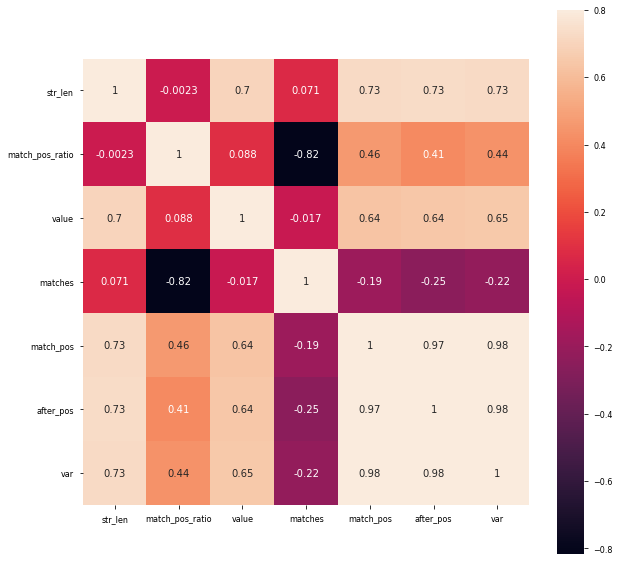

In [196]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=0.8, square=True, annot=True)

In [197]:
df_same_regex_new_nonmatching2.head()

,str_len,match_pos_ratio,Benchmark,value,matches,match_pos,after_pos,var
0,1024,1.0,regexMatches,5577,False,1024,1024,1024
1,128,1.0,regexMatches,293,False,128,128,128
2,16,1.0,regexMatches,100,False,16,16,16
3,16384,1.0,regexMatches,88429,False,16384,16384,16384
4,2048,1.0,regexMatches,11931,False,2048,2048,2048


In [198]:
df_regex = df_same_regex_new_nonmatching2.loc[df_same_regex_new_nonmatching2["Benchmark"] == "regexMatches", :]
df_str = df_same_regex_new_nonmatching2.loc[df_same_regex_new_nonmatching2["Benchmark"] != "regexMatches", :]

In [199]:
df_regex.corr(method = "spearman")

,str_len,match_pos_ratio,value,matches,match_pos,after_pos,var
str_len,1.000000,-0.002318,0.969177,0.070604,0.730088,0.734151,0.734151
match_pos_ratio,-0.002318,1.000000,-0.110695,-0.815697,0.464230,0.406537,0.406537
value,0.969177,-0.110695,1.000000,0.053390,0.631531,0.681948,0.681948
matches,0.070604,-0.815697,0.053390,1.000000,-0.190609,-0.253833,-0.253833
match_pos,0.730088,0.464230,0.631531,-0.190609,1.000000,0.968474,0.968474
after_pos,0.734151,0.406537,0.681948,-0.253833,0.968474,1.000000,1.000000
var,0.734151,0.406537,0.681948,-0.253833,0.968474,1.000000,1.000000


In [200]:
df_str.corr(method = "spearman")

,str_len,match_pos_ratio,value,matches,match_pos,after_pos,var
str_len,1.000000,-0.002318,0.801304,0.070604,0.730088,0.734151,0.730088
match_pos_ratio,-0.002318,1.000000,0.325932,-0.815697,0.464230,0.406537,0.464230
value,0.801304,0.325932,1.000000,-0.077657,0.975327,0.948011,0.975327
matches,0.070604,-0.815697,-0.077657,1.000000,-0.190609,-0.253833,-0.190609
match_pos,0.730088,0.464230,0.975327,-0.190609,1.000000,0.968474,1.000000
after_pos,0.734151,0.406537,0.948011,-0.253833,0.968474,1.000000,0.968474
var,0.730088,0.464230,0.975327,-0.190609,1.000000,0.968474,1.000000


In [241]:
df_same_regex_new_nonmatching2["value_log2"] = df_same_regex_new_nonmatching2['value'].apply(lambda x: math.log2(x))
df_same_regex_new_nonmatching2["str_len_log2"] = df_same_regex_new_nonmatching2['str_len'].apply(lambda x: math.log2(x))

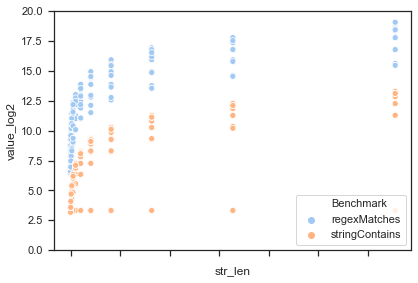

In [253]:
sns.set(style="ticks", palette="pastel")
ax = sns.scatterplot(x="str_len", y="value_log2",
            hue="Benchmark", 
            data=df_same_regex_new_nonmatching2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(0,20)
# sns.scatterplot(data=df_http0, x="match_pos_ratio", y="regexMatches", hue="str_len") #err_style="bars")
plt.legend(loc="best")

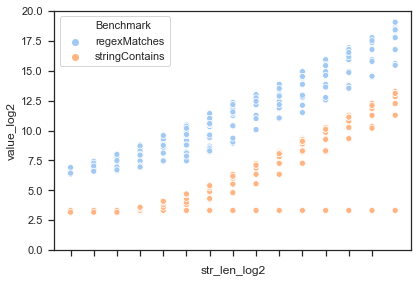

In [254]:
sns.set(style="ticks", palette="pastel")
ax = sns.scatterplot(x="str_len_log2", y="value_log2",
            hue="Benchmark", 
            data=df_same_regex_new_nonmatching2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(0,20)
# sns.scatterplot(data=df_http0, x="match_pos_ratio", y="regexMatches", hue="str_len") #err_style="bars")
plt.legend(loc="best")
ax.set_xticks(np.arange(2,16,1))

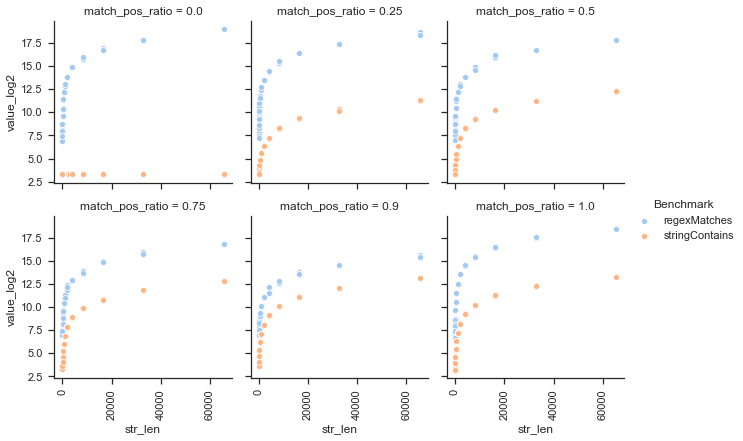

In [255]:
grid = sns.FacetGrid(df_same_regex_new_nonmatching2, col = "match_pos_ratio", hue = "Benchmark", col_wrap=3)
grid.map(sns.scatterplot, "str_len", "value_log2")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

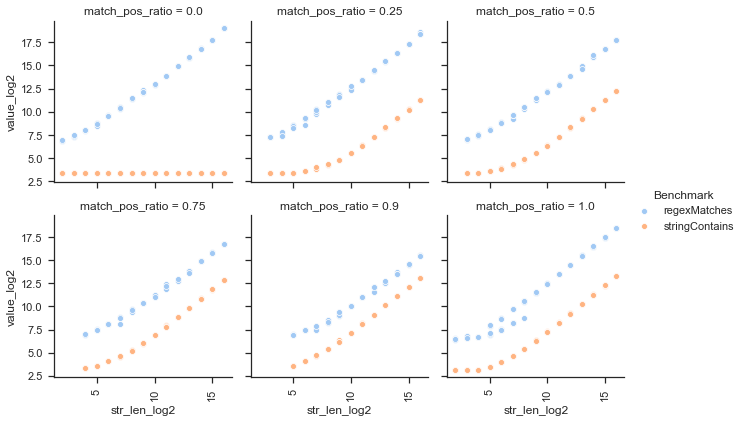

In [256]:
grid = sns.FacetGrid(df_same_regex_new_nonmatching2, col = "match_pos_ratio", hue = "Benchmark", col_wrap=3)
grid.map(sns.scatterplot, "str_len_log2", "value_log2")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

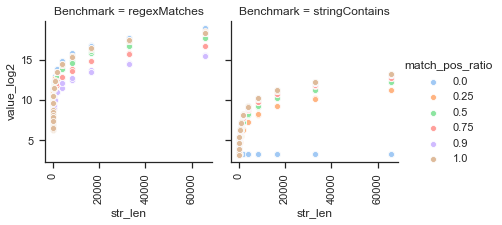

In [257]:
grid = sns.FacetGrid(df_same_regex_new_nonmatching2, col = "Benchmark", hue = "match_pos_ratio", col_wrap=2)
grid.map(sns.scatterplot, "str_len", "value_log2")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

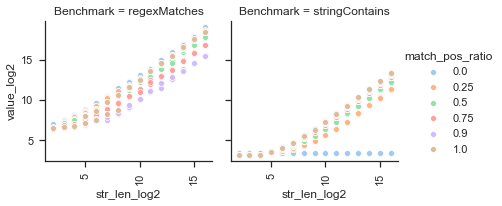

In [258]:
grid = sns.FacetGrid(df_same_regex_new_nonmatching2, col = "Benchmark", hue = "match_pos_ratio", col_wrap=2)
grid.map(sns.scatterplot, "str_len_log2", "value_log2")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

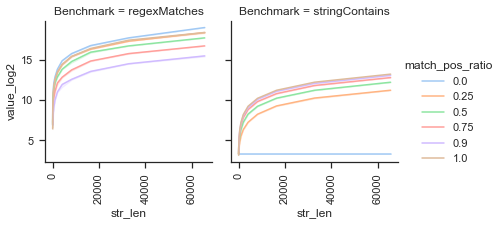

In [259]:
grid = sns.FacetGrid(df_same_regex_new_nonmatching2, col = "Benchmark", hue = "match_pos_ratio", col_wrap=2)
grid.map(sns.lineplot, "str_len", "value_log2")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

<Figure size 1440x720 with 0 Axes>

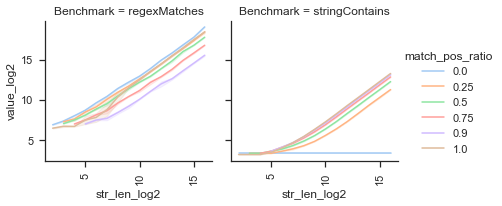

In [269]:
fig = plt.figure(figsize=(20,10))
grid = sns.FacetGrid(df_same_regex_new_nonmatching2, col = "Benchmark", hue = "match_pos_ratio", col_wrap=2)
grid.map(sns.lineplot, "str_len_log2", "value_log2", err_style='band', estimator='mean', ci="sd")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

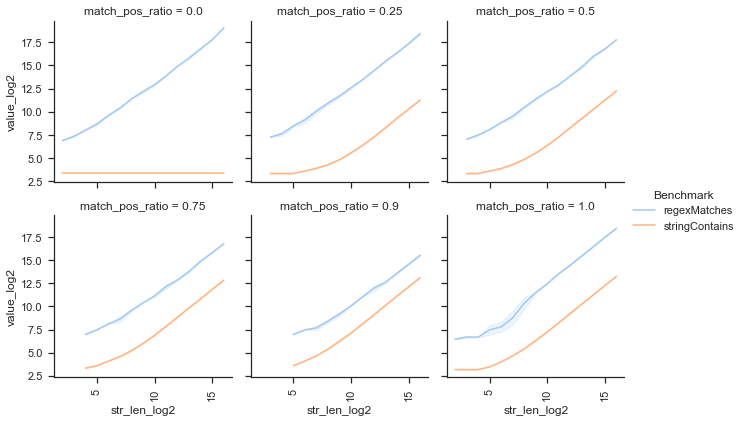

In [270]:
grid = sns.FacetGrid(df_same_regex_new_nonmatching2, col = "match_pos_ratio", hue = "Benchmark", col_wrap=3)
grid.map(sns.lineplot, "str_len_log2", "value_log2", err_style='band', estimator='mean', ci="sd")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()